In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Jupyterの表示オプション
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# エクセルファイルの読み込み
# SIS日刊データ
SIS_df=pd.read_excel("SIS分析プロジェクト_日刊60日切り-週間100データ対応_容量削減ver_200819.xlsm",
                     sheet_name="日毎データ累積",
                     header=1,
                     encoding="cp932",
                     na_values=["データなし","-"])
SIS_df_droped=SIS_df.dropna(subset=["機種名","客滞"])
SIS_df_droped['機種名']=SIS_df_droped['機種名'].str.strip()
SIS_df_droped=SIS_df_droped[~SIS_df_droped['機種名'].str.contains("海物語")]
SIS_df_droped=SIS_df_droped[(SIS_df_droped["客滞"] <= 200)]

# 市場スペックデータ
Spec_df=pd.read_excel("右打ちチェック用市場データ改β.xlsm",
                      sheet_name="データベース",                      
                      encoding="cp932")
df_renamed=Spec_df.rename(columns={"Product_name":"機種名",
                                    "Oneshot_Rate":"単発率",
                                    "SurfaceCont_Rate":"名目継続率",
                                    "HeavenRush_Rate":"天国突入率",
                                    "HeavenTY_Ave":"天国TY平均",
                                    "FirtstT1Y_Ave":"初回平均T1Y",
                                    "GuessSimMY_Ave":"平均MY"})
# 継続率をビン分割
Cont_bins = [0,0.5,0.6,0.7,0.8,0.9,1]
TS_bins = [0,70,150,220,270,320]
Contbins_names=["継続0%-50%","継続50%-60%","継続60%-70%","継続70%-80%","継続80%-90%","継続90%-100%"]
TSbins_names=["甘未満","甘デジ","ライトミドル","ミドル","ハイミドル"]
# dfにビンの列を追加
df_renamed["継続率帯"] = pd.cut(df_renamed["名目継続率"], Cont_bins, labels=Contbins_names)
df_renamed["TS帯"] = pd.cut(df_renamed["TS"], TS_bins, labels=TSbins_names)

# 過去機種データベース
Product_df=pd.read_excel("過去機種データベースまとめ_200416.xlsx",
                         sheet_name="オール機種 数値化",
                         header=11,
                         encoding="cp932")

<ipython-input-92-ebf235e9e1ea>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SIS_df_droped['機種名']=SIS_df_droped['機種名'].str.strip()


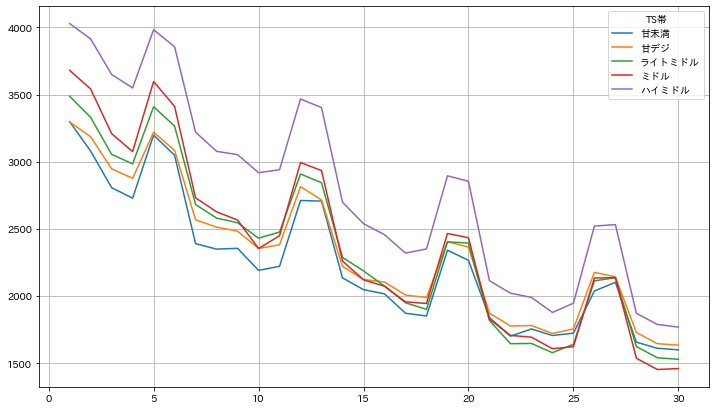

In [70]:
pivot_SIS_df=SIS_df_droped.pivot_table(index="機種名", 
                                       columns="導入日数",
                                       values="アウト",
                                       aggfunc="mean")
                                   
# 対象となる日付をリスト化して保持
date_list=list(pivot_SIS_df.columns)
# データフレームの結合
merge_df=pd.merge(left=pivot_SIS_df,
                  right=df_renamed,
                  left_index=True,
                  right_on="機種名",
                  how="left")
grouped=merge_df.groupby("TS帯").mean()[date_list].T.iloc[0:30]
grouped.plot(figsize=(12,7),grid=True)

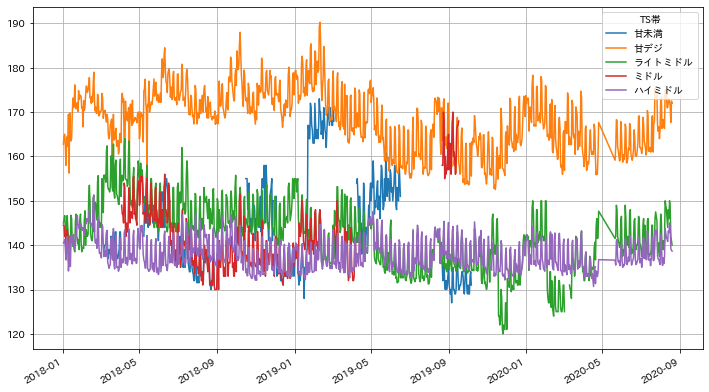

In [71]:
#　客滞の集計表示
SIS_df_droped=SIS_df_droped.set_index("日付")["2018-01-01":].reset_index()
pivot_SIS_df=SIS_df_droped.pivot_table(index="機種名", 
                                       columns="日付",
                                       values="客滞",
                                       aggfunc="mean")
# 対象となる日付をリスト化して保持
date_list=list(pivot_SIS_df.columns)
# データフレームの結合
merge_df=pd.merge(left=pivot_SIS_df,
                  right=df_renamed,
                  left_index=True,
                  right_on="機種名",
                  how="left")
grouped=merge_df.groupby("TS帯").mean()[date_list].T
grouped.plot(figsize=(12,7),grid=True)

/Users/kfuruhashi/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


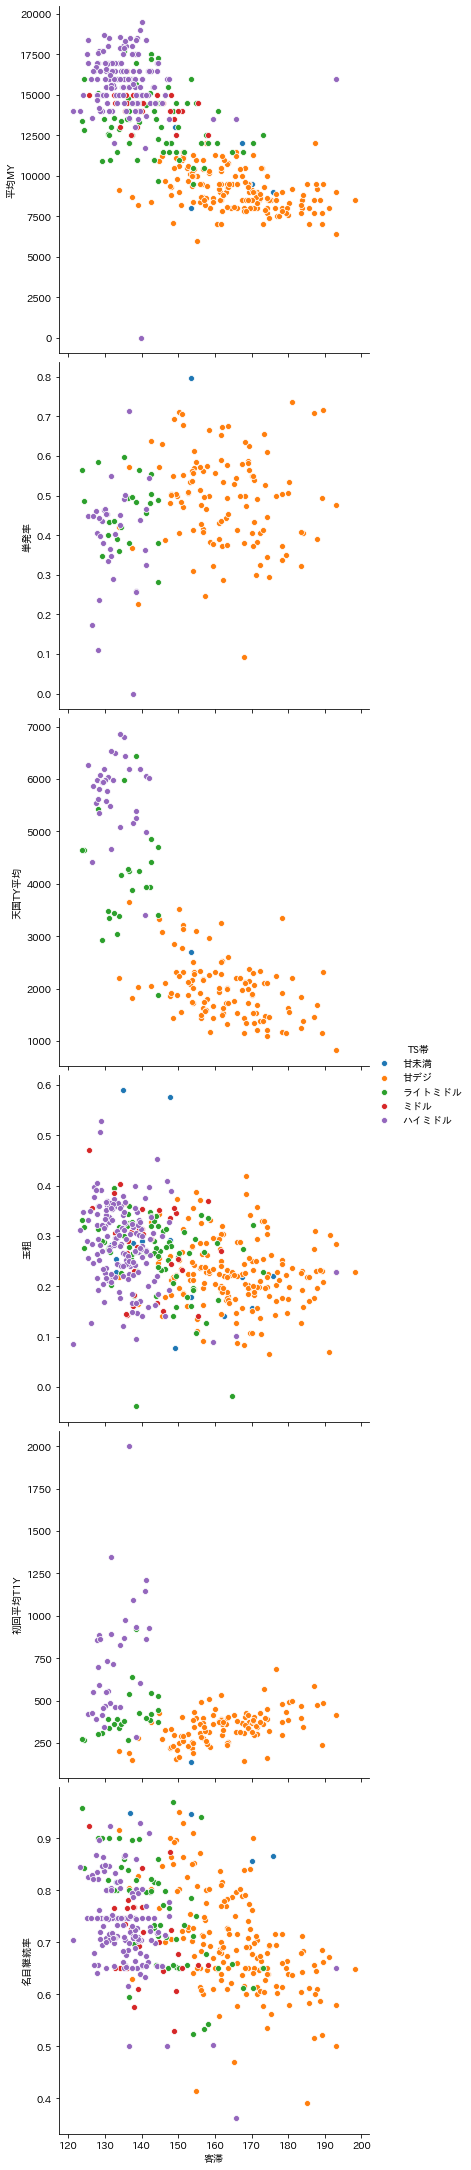

In [94]:
# 必要項目毎の機種別平均データに変換
pivot_SIS_df=SIS_df_droped.pivot_table(index="機種名", 
                                       values=["客滞","玉粗","TO","アウト"],
                                       aggfunc="mean")
# データフレームの結合
merge_df=pd.merge(left=pivot_SIS_df,
                  right=df_renamed,
                  left_index=True,
                  right_on="機種名",
                  how="left") 
sns.pairplot(data=merge_df,
             hue="TS帯",
             x_vars="客滞",
             y_vars=["平均MY","単発率","天国TY平均","玉粗","初回平均T1Y","名目継続率"],
             size=5)
merge_df_forcsv=merge_df[(merge_df["TS帯"]=="甘デジ")]
merge_df_forcsv=merge_df_forcsv.loc[:,["機種名","平均MY","単発率","客滞","初回平均T1Y","天国TY平均","玉粗","名目継続率"]] \
                                .set_index("機種名")
merge_df_forcsv .to_csv("客滞データ.csv")

,code,Product_name,Date,Main_Flag,Main_Code,Operate_Week,Type,SmallRush_Flag,Set_Flag,Hiding_Flag,Top_Flag,MultiTS_Flag,TS,DirectRush_Rate,FirstJitnum_Ave,Oneshot_Rate,FirtstT1Y_Ave,TSA,TotalCont_Ave,SurfaceCont_Rate,SecondJitnum_Ave,SecondT1Y_max,SecondT1YMax_Rate,SecondT1Y_Ave,TY_Ave,TY_over25_Rate,TY_over50_Rate,TY_over100_Rate,TO_Ave,HeavenRush_Rate,HeavenTY_Ave,HeavenCont_Ave,GuessSimMY_Ave,RealSimMY_Ave,Win_Rate,Branch_Start,T1yen_Start,Out_FirstDay,Out_1w,Out_2w,Out_3w,Out_4w,Out_5w,Out_6w,Out_7w,Out_8w,Out_9w,Out_10w,Out_11w,Out_12w,Out_13w,Dnum_1w,Dnum_2w,Dnum_3w,Dnum_4w,Dnum_5w,Dnum_6w,Dnum_7w,Dnum_8w,Dnum_9w,Dnum_10w,Dnum_11w,Dnum_12w,Dnum_13w
0,1,CRトラック野郎LR-T,2014-01-06,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,299.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,221.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16000.0,NaN,NaN,5.870,NaN,NaN,3974,4179.0,3476.0,2459.0,2147.0,1833.0,1695.0,1537.0,1342.0,1300.0,1223.0,1273.0,1182.0,260,1160.0,1450.0,1470.0,1450.0,1440.0,1400.0,1350.0,1320.0,1280.0,1260.0,1300.0,1130.0
1,8,CRぱちんこ仮面ライダーＶ３ L1,2014-01-13,NaN,NaN,31.0,NaN,NaN,NaN,NaN,NaN,NaN,99.9,NaN,NaN,NaN,NaN,NaN,NaN,0.712246,NaN,133.0,NaN,742.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10500.0,NaN,NaN,5.730,17.600,NaN,4281,3985.0,3479.0,3275.0,3053.0,2953.0,2752.0,2518.0,2492.0,2331.0,2359.0,2239.0,2164.0,2110,2980.0,2970.0,2990.0,2990.0,3000.0,3000.0,2980.0,2970.0,2960.0,3240.0,2950.0,2930.0
2,6,CRA春夏秋冬 極上～粋な祭りだ！はっぴぃ！～,2014-01-13,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,99.9,NaN,NaN,NaN,NaN,NaN,NaN,0.665876,NaN,122.0,NaN,880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000.0,NaN,NaN,5.990,18.700,NaN,3868,3510.0,2795.0,2709.0,2581.0,2568.0,2530.0,2310.0,2282.0,2197.0,2195.0,2164.0,2137.0,210,310.0,320.0,320.0,330.0,330.0,360.0,360.0,380.0,390.0,430.0,400.0,400.0
3,7,CRゲゲゲの鬼太郎 地獄からの使者FPW,2014-01-13,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,99.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,152.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9500.0,NaN,NaN,5.910,NaN,NaN,3470,3024.0,2321.0,2073.0,1876.0,1759.0,1628.0,1393.0,1369.0,1272.0,1330.0,1258.0,1231.0,460,700.0,710.0,720.0,750.0,750.0,730.0,710.0,680.0,670.0,720.0,610.0,590.0
4,2,CRダービースタリオンXX･Y,2014-01-13,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14000.0,NaN,NaN,5.580,NaN,NaN,3631,2932.0,1893.0,1674.0,1438.0,1379.0,1250.0,1040.0,1011.0,902.0,898.0,870.0,871.0,1140,1550.0,1530.0,1510.0,1450.0,1360.0,1230.0,1150.0,1090.0,1010.0,1060.0,820.0,730.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,897,Pうる星やつらN-K,2020-05-11,0.0,771.0,NaN,ST,0.0,0.0,0.0,0.0,0.0,99.9,0.55,50.0,0.42842,285.2,87.3,2.882,0.684000,0.0,713.2,0.5,534.9,1172.2,NaN,NaN,NaN,1077.5,0.73709,1444.6,3.297,8700.0,7900.0,NaN,6.199,21.288,1492.0,1876,1535.0,1401.0,1292.0,1227.0,1185.0,1139.0,1112.0,NaN,NaN,NaN,NaN,NaN,1060,1050.0,1040.0,990.0,930.0,860.0,650.0,500.0,NaN,NaN,NaN,NaN,NaN
898,898,Pリング 呪いの７日間２ JN,2020-05-11,NaN,NaN,2.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2520,2127.0,1979.0,1877.0,1846.0,1782.0,1683.0,1751.0,1836.0,NaN,NaN,NaN,NaN,2490,2350.0,2290.0,2220.0,2130.0,2000.0,1830.0,1580.0,560.0,NaN,NaN,NaN,NaN
899,900,P元祖大工の源さんWCC,2020-05-11,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1576,1205.0,1063.0,911.0,884.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1070,1030.0,930.0,840.0,720.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
900,901,Pひぐらしのなく頃に～廻～AG-S,2020-05-11,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1733,1500.0,1420.0,1320.0,1306.0,1289.0,1305.0,1323.0,NaN,NaN,NaN,NaN,NaN,710,710.0,690.0,680.0,650.0,590.0,540.0,500.0,